https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/

The Cycle Generative adversarial Network, or CycleGAN for short, is a generator model for converting images from one domain to another domain.

For example, the model can be used to translate images of horses to images of zebras, or photographs of city landscapes at night to city landscapes during the day.

The benefit of the CycleGAN model is that it can be trained without paired examples. That is, it does not require examples of photographs before and after the translation in order to train the model, e.g. photos of the same city landscape during the day and at night. Instead, it is able to use a collection of photographs from each domain and extract and harness the underlying style of images in the collection in order to perform the translation.

The model architecture is comprised of two generator models: one generator (Generator-A) for generating images for the first domain(Domain-A) and the second geenrator (Generator-B) for generating images for the second domain (Domain-B)
- Generator-A -> Domain-A
- Generator-B -> Domain-B

The generator models perform image translation, meaning that the image generation process is conditional on an input image, specifically an image from the other domain. Generator-A takes an image from Domain-B as input and Generator-B takes an image from Domain-A as input.
- Domain-B -> Generator-A -> Domain-A
- Domain-A -> Generator-B -> Domain-B

Each generator has a corresponding discriminator model.
The first discriminator model (Discriminator-A) takes real images from Domain-A and generated images from Generator-A and predicts whether they are real or fake. The second discriminator model (Discriminator-B) takes real images from Domain-B and generated images from Generator-B and predicts whether they are real or fake.
- Domain-A -> Discriminator-A -> [Real/Fake]
- Domain-B -> Generator-A -> Discriminator-A -> [Real/Fake]
- Domain-B -> Discriminator-B -> [Real/Fake]
- Domain-A -> Generator-B -> Discriminator-B -> [Real/Fake]

The discriminator and generator models are trained in an adversarial zero-sum process, like normal GAN models.

The generators learn to better fool the discriminators and the discriminators learn to better detect fake images. Together, the models find an equilibrium during the training process.

Additionally, the generator models are regularized not just to create new images in the target domain, but instead create translated versions of the input images from the source domain. This is achieved by using generated images as input to the corresponding generator model and comparing the output image to the original images.

Passing an image through both generators is called a cycle. Together, each pair of generator models are trained to better reproduce the original source image, referred to as cycle consistency.
- Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
- Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A

There is one further element to the architecture referred to as the identity mapping.
This is where a generator is provided with images as input from the target domain and is expected to generate the same image without change. This addition to the architecture is optional, although it results in a better matching of the color profile of the input image.
- Domain-A -> Generator-A -> Domain-A
- Domain-B -> Generator-B -> Domain-B

####  Implement the CycleGAN Discriminator Model

The discriminator model is responsible for taking a real or generated image as input and predicting whether it is real or fake. The discriminator model is implemented as PatchGAN model (70X70 PatchGANs - which aims to classify whether 70X70 overlapping image patches are real or fake).


… we design a discriminator architecture – which we term a PatchGAN – that only penalizes structure at the scale of patches. This discriminator tries to classify if each NxN patch in an image is real or fake. We run this discriminator convolutionally across the image, averaging all responses to provide the ultimate output of D.

##### Discriminator architecture
For discriminator networks,
we use 70  70 PatchGAN [15]. Let Ck denote
a 4  4 Convolution-BatchNorm-LeakyReLU layer with
k filters and stride 2. After the last layer, we apply a
convolution andto produce a 1 dimensional output. We do
not use BatchNorm for the first C64 layer. We use leaky
ReLUs with slope 0:2. The discriminator architecture is:
C64-C128-C256-C512

- C64-C128-C256-C512
This is referred to as a 3-layer PatchGAN in the CycleGAN and Pix2Pix nomenclature, as excluding the first hidden layer, the model has three hidden layers that could be scaled up or down to give different sized PatchGAN models.

Not listed in the paper, the model also has a final hidden layer C512 with a 1×1 stride, and an output layer C1, also with a 1×1 stride with a linear activation function. Given the model is mostly used with 256×256 sized images as input, the size of the output feature map of activations is 16×16. If 128×128 images were used as input, then the size of the output feature map of activations would be 8×8

The model does not use batch normalization; instead, ### instance normalization ### is used.
Instance Normalization: https://arxiv.org/abs/1607.08022
Instance normalization was described in the 2016 paper titled “Instance Normalization: The Missing Ingredient for Fast Stylization.” It is a very simple type of normalization and involves standardizing (e.g. scaling to a standard Gaussian) the values on each feature map.
The intent is to remove image-specific contrast information from the image during image generation, resulting in better generated images.

"The key idea is to replace batch normalization layers in the generator architecture with instance normalization layers, and to keep them at test time (as opposed to freeze and simplify them out as done for batch normalization). Intuitively, the normalization process allows to remove instance-specific contrast information from the content image, which simplifies generation. In practice, this results in vastly improved images."

Although designed for generator models, it can also prove effective in discriminator models.

An implementation of instance normalization is provided in the keras-contrib project that provides early access to community-supplied Keras features.

The keras-contrib library can be installed via pip as follows:

In [2]:
#for instance normalization
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\rapathak\appdata\local\temp\pip-req-build-dbbucind
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101659 sha256=5c2909d75455992fdee50cf00b98ee6cf779144553c1c8faede8e2f3eb307fb4
  Stored in directory: C:\Users\rapathak\AppData\Local\Temp\pip-ephem-wheel-cache-8fkvwlae\wheels\67\d2\f4\96ae3c3c62d1e05abfc8860ad0c1207794726d44ebbbb547f3
Successfully built keras-contrib


#### Key points for Discriminator
- Use instance normalization
- The network weights are initialized to Gaussian random numbers with a standard deviation of 0.02
- The discriminator model is updated using a least squares loss (L2), a so-called Least-Squared Generative Adversarial Network, or LSGAN.  : We replace the negative log likelihood objective by a least-squares loss. This loss is more stable during training and generates higher quality results  .  This can be implemented using “mean squared error” between the target values of class=1 for real images and class=0 for fake images.
- the paper suggests dividing the loss for the discriminator by half during training, in an effort to slow down updates to the discriminator relative to the generator. This can be achieved by setting the “loss_weights” argument to 0.5 when compiling the model. 

In [23]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model

#load, split and scale the maps dataset ready for trainig
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


In [2]:
#define a 70*70 patchgan discriminator model
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev=0.02)
    #source image input 
    in_image = Input(shape=image_shape)
    #C64
    d = Conv2D(64,(4,4),strides=(2,2),padding='same', kernel_initializer=init,name='Conv2D-1-C64')(in_image)
    d = LeakyReLU(alpha = 0.2)(d)
    
    #C128
    d = Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init,name='Conv2D-2-C128')(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    #C256
    d = Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init,name='Conv2D-3-C256')(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    #C512
    d = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init,name='Conv2D-4-C512')(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    #second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init,name='Conv2D-5-C512')(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    #patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init,name='Conv2D-6-C1')(d)
    
    #define model
    model = Model(in_image,patch_out)
    
    #compile model
    model.compile(loss='mse',optimizer=Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D-1-C64 (Conv2D)        (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
Conv2D-2-C128 (Conv2D)       (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
Conv2D-3-C256 (Conv2D)       (None, 32, 32, 256)       524544

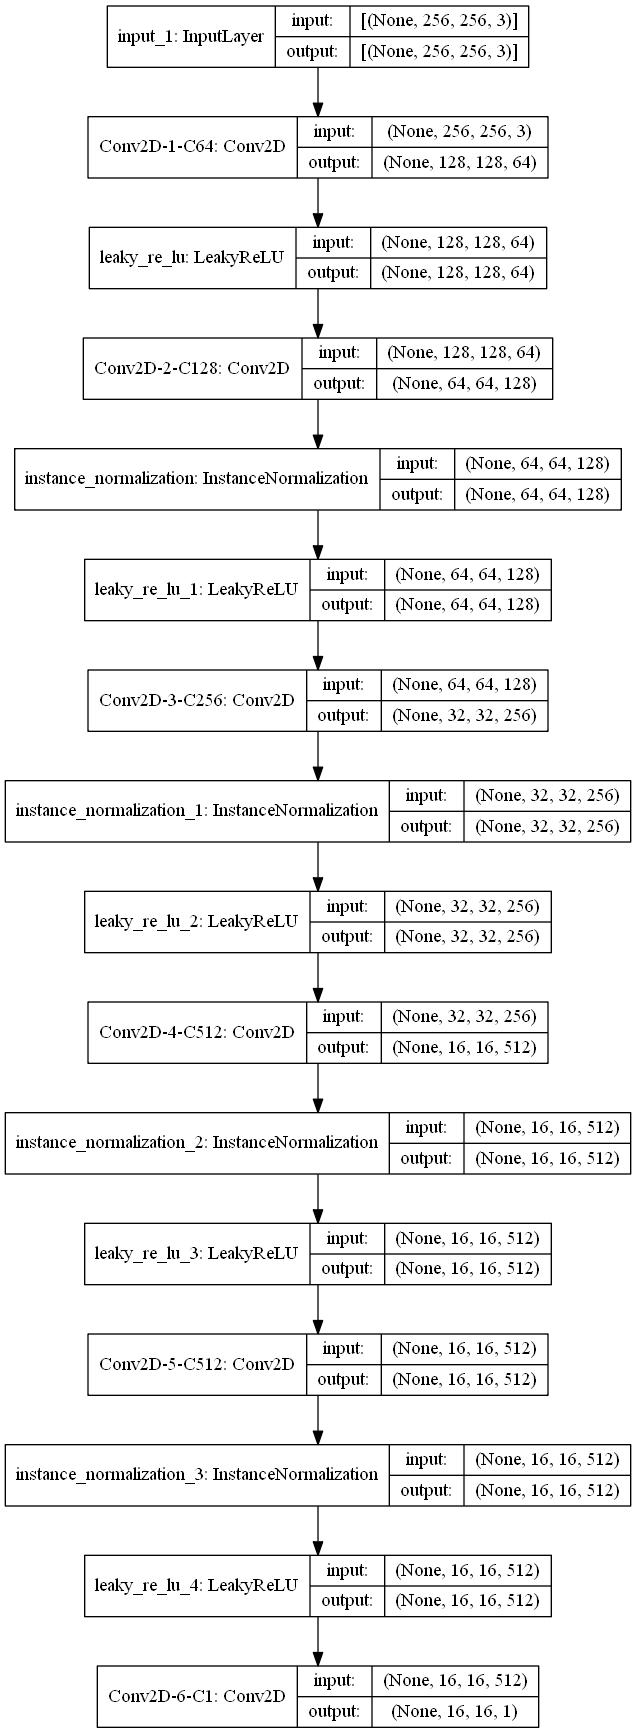

In [3]:
#test above discriminator code
image_shape =(256,256,3)
model = define_discriminator(image_shape)
#summary
model.summary()
plot_model(model,to_file='discriminator_model_plot.png',show_shapes=True,show_layer_names=True)

#### Implement the CycleGAN Generator Model

The CycleGAN Generator model takes an image as input and generates a translated image as output.

The model uses a sequence of downsampling convolutional blocks to encode the input image, a number of residual network (ResNet) convolutional blocks to transform the image, and a number of upsampling convolutional blocks to generate the output image.

"Let c7s1-k denote a 7×7 Convolution-InstanceNormReLU layer with k filters and stride 1. dk denotes a 3×3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2. Reflection padding was used to reduce artifacts. Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layer. uk denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride 1/2."

- The network with 6 blocks consists of:
c7s1-32,d64,d128,R128,R128,R128,R128,R128,R128,u64,u32,c7s1-3

- The network with 9 blocks consists of:
c7s1-32,d64,d128,R128,R128,R128,R128,R128,R128,R128,R128,R128,u64,u32,c7s1-3

In [4]:
#define reflective padding
#https://github.com/mronta/CycleGAN-in-Keras/blob/master/reflection_padding.py
import tensorflow as tf
from keras.engine.topology import Layer
from keras.engine import InputSpec

class ReflectionPadding2D_old(Layer):
    '''
    Implements Reflection Padding as a layer
    
    Args: padding(tuple): Amount of padding for the spatial dimensions.
    
    Returns: A padded tensor with the same type as the input tensor
    '''
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def get_output_shape_for(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'num_layers': self.num_layers,
            'units': self.units,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout': self.dropout,
        })
        return config

In [5]:
class ReflectionPadding2D(Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'num_layers': self.num_layers,
            'units': self.units,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout': self.dropout,
        })
        return config

In [6]:
#test for reflective padding
# a little Demo
inputs = Input((256, 256, 3))
padded_inputs= ReflectionPadding2D(padding=(1,1))(inputs)
conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform',
               data_format='channels_last')(padded_inputs)
m = Model(inputs,conv1)
m.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
reflection_padding2d (Reflec (None, 258, 258, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 258, 258, 32)      896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


#### Define ResNet Block

In [7]:
def resnet_block(n_filters,input_layer):
    #weiht initialization
    init = RandomNormal(stddev=0.02)
    
    #first layer convolution layer
    
    g = ReflectionPadding2D()(input_layer)
    g = Conv2D(n_filters,(3,3),kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    #second convolution layer
    g = ReflectionPadding2D()(input_layer)
    g = Conv2D(n_filters, (3,3), kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g

In [8]:
def define_generator(image_shape=(256,256,3), n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape, name="Generator" + "_img_input")
    # c7s1-64
    g = ReflectionPadding2D(padding=(3, 3))(in_image)
    g = Conv2D(64, (7,7), kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    # c7s1-3
    g = ReflectionPadding2D(padding=(3, 3))(g)
    g = Conv2D(3, (7,7), padding='valid', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [9]:
# create the model
model = define_generator()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_img_input (InputLayer [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 262, 262, 3)  0           Generator_img_input[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 9472        reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
instance_normalization_4 (Insta (None, 256, 256, 64) 128         conv2d_1[0][0]                   
____________________________________________________________________________________________

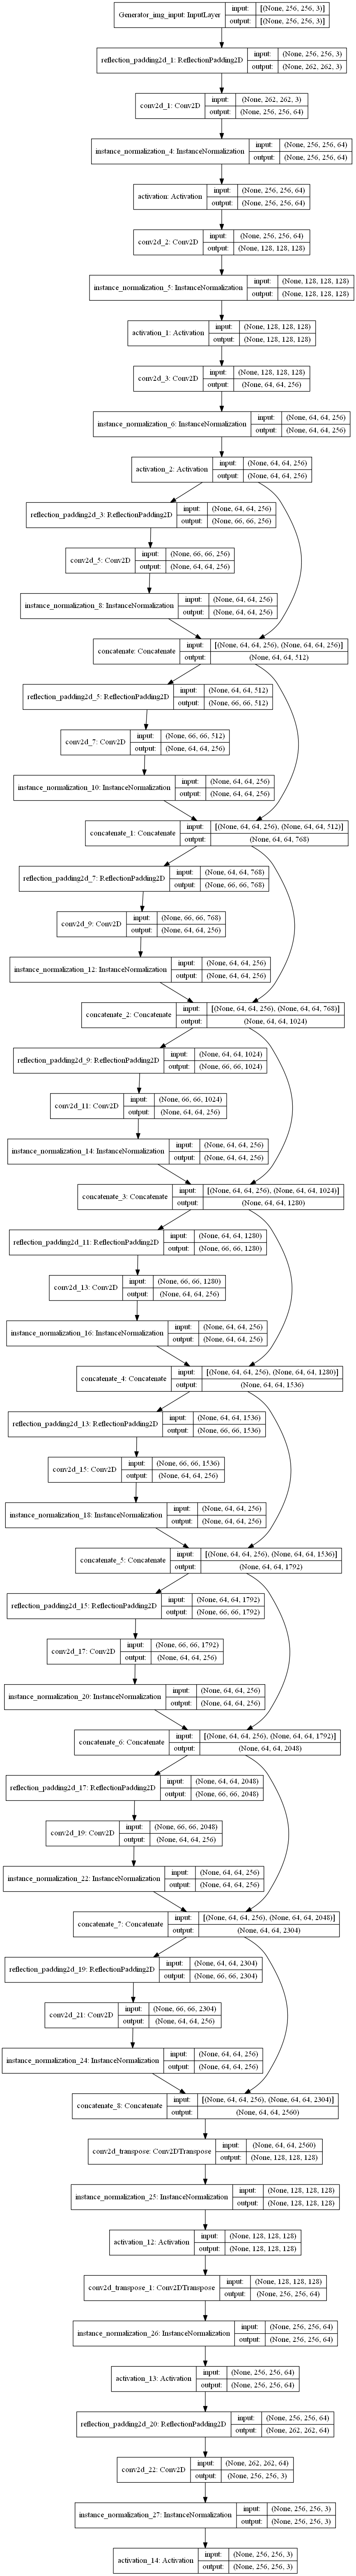

In [10]:
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

#### Implement Composite Models for Least Squares and Cycle Loss

The generator models are not updated directly. Instead, the generator models are updated via composite models.

An update to each generator model involves changes to the model weights based on four concerns:
- Adversarial loss (l2 or mean squared error)
- Identity loss(L1 or mean absolute error)
- Forward cycle loss( L1 or mean absolute)
- Backward cycle loss( L1 or mean absolute error)

The adversarial loss is the standard approach for updating the generator via the discriminator, although in this case, the least squares loss function is used instead of the negative log likelihood (e.g. binary cross entropy).

In [11]:
#define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model,g_model_2,image_shape):
    
    #ensure that the model we are updating is trainable
    g_model_1.trainable=True
    
    #mark discrimator as not trainable
    d_model.trainable = False
    
    #mark other generator model as not trainable
    g_model_2.trainable = False
    
    #discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    
    #identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    
    #forward cycle
    output_f = g_model_2(gen1_out)
    
    #backword cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    
    #define model graph
    model =Model([input_gen,input_id],[output_d,output_id,output_f,output_b])
    
    #define optimization algorithm configuration
    opt = Adam(lr=0.0002,beta_1=0.5)
    
    #compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse','mae','mae','mae'], loss_weights=[1,5,10,10],optimizer=opt)
    
    return model
    

We can summarize the inputs and outputs for each of the composite models below. Recall that we are sharing or reusing the same set of weights if a given model is used more than once in the composite model.

##### Generator-A Composite Model
Only generator -A weights are trainable and weights for the other models are not trainable
- Adversarial loss : Domain B -> Generator A -> Domain A -> Discriminator A -> [real/fake]
- Identity loss : Domain A -> Generator A -> Domain- A
- Forward cycle loss : Domain B -> Generator A -> Domain A -> Generator B -> Domain B
- Backward Cycle loss :  Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A

##### Generator-B Composite Model
Only generator -B weights are trainable and weights for the other models are not trainable
- Adversarial loss : Domain A -> Generator B -> Domain B -> Discriminator B -> [real/fake]
- Identity loss : Domain B -> Generator B -> Domain- B
- Forward cycle loss : Domain A -> Generator B -> Domain B -> Generator A -> Domain A
- Backward Cycle loss :  Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B

##### Create models

In [12]:
#input shape
image_shape = (256,256,3)

#generator : A->B
g_model_AtoB = define_generator(image_shape)

#generator : B->A
g_model_BtoA = define_generator(image_shape)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)

# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)

# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [13]:
g_model_AtoB.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_img_input (InputLayer [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
reflection_padding2d_21 (Reflec (None, 262, 262, 3)  0           Generator_img_input[0][0]        
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 64) 9472        reflection_padding2d_21[0][0]    
__________________________________________________________________________________________________
instance_normalization_28 (Inst (None, 256, 256, 64) 128         conv2d_23[0][0]                  
____________________________________________________________________________________________

#### Update Discriminator and Generator Models
We will model the order of updates based on the implementation in the official Torch implementation:
1. Update Generator B (A->B)
2. Update Discriminator - B
3. Update Generator-A (B->A)
4. Update Discriminator-A

In [14]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    #ix = randint(0, dataset.shape[0], n_samples)
    ix = random.sample(range(0, dataset.shape[0]), n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [15]:
def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake instance
    X = g_model.predict(dataset)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

The paper describes using a pool of previously generated images from which examples are randomly selected and used to update the discriminator model, where the pool size was set to 50 images

[we] update the discriminators using a history of generated images rather than the ones produced by the latest generators. We keep an image buffer that stores the 50 previously created images.

In [43]:
import random 
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = random.randint(0, len(pool)-1)
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

In [44]:
#train cyclegan models
def train(d_model_A, d_model_B,g_modelAtoB,g_model_BtoA,c_model_AtoB,c_model_BtoA,dataset):
    #define parameters
    n_epochs, n_batch = 100,1
    
    #determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    
    #unpack dataset
    
    trainA, trainB = dataset['arr_0'], dataset['arr_1']
    
    #prepare image pool for fakes
    poolA, poolB = list(), list()
    
    #calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA)/n_batch)
    
    #calculate the number of traiing iterations
    n_steps = bat_per_epo * n_epochs
    
    for i in range(n_steps):
        #select a bacth of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        
        #generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        
        #update the fake pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

        

#### Load dataset and train models.

In [18]:
def load_images(path, type='train', size=(256,256)):
    A_list, B_list = list(), list()
    #enumerate filenames in directory , assume all are images
    if type == 'train':
        A_path = path+'trainA/'
        B_path = path+'trainB/'
    else:
        A_path = path+'testA/'
        B_path = path+'testB/'
    
    
    for filename in listdir(A_path):
        # load and resize the image
        pixels = load_img(A_path+filename,target_size=size)
        #convert to numpy array
        pixels = img_to_array(pixels)
        A_list.append(pixels)
        
    for filename in listdir(B_path):
        # load and resize the image
        pixels = load_img(B_path+filename,target_size=size)
        #convert to numpy array
        pixels = img_to_array(pixels)
        B_list.append(pixels)
        
    return [asarray(A_list),asarray(B_list)]

In [69]:

path = 'ukiyoe2photo/'
#load dataset
[A_imges,B_images] = load_images(path)
print('loaded train data: ',A_imges.shape, B_images.shape)
# save as compressed numpy array
filename = 'train_data_256.npz'
savez_compressed(filename, A_imges, B_images)
print('Saved dataset: ', filename)



Saved dataset:  train_data_256.npz


In [71]:
[A_list_test,B_list_test] = load_images(path,type='test')
print('loaded test data: ',A_list_test.shape, B_list_test.shape)
# save as compressed numpy array
filename1 = 'test_data_256.npz'
savez_compressed(filename1, A_list_test, B_list_test)
print('Saved dataset: ', filename1)

loaded test data:  (263, 256, 256, 3) (751, 256, 256, 3)
Saved dataset:  test_data_256.npz


Loaded:  (562, 256, 256, 3) (6287, 256, 256, 3)


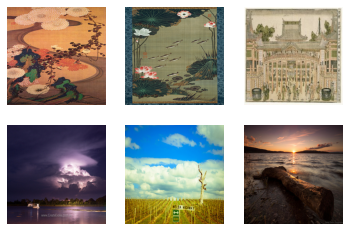

In [19]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('train_data_256.npz')
A_images, B_images = data['arr_0'], data['arr_1']
print('Loaded: ', A_images.shape, B_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(A_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(B_images[i].astype('uint8'))
pyplot.show()

In [20]:
trainA1, trainB1 = data
A_images, B_images = data['arr_0'], data['arr_1']

In [21]:
A_images.shape[0]
import random
#ix = randint(0, A_images.shape[0], 10)
ix = random.sample(range(0, A_images.shape[0]),4)
ix

[189, 67, 175, 214]

In [33]:
import random 
random.randint(0, 50)

37

In [45]:
import random
from numpy import ones
from numpy import zeros
# load a dataset as a list of two numpy arrays
#dataset = load('train_data_256.npz')
dataset = data
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

>1, dA[0.051,0.041] dB[0.065,0.033] g[3105.986,3497.626]
>2, dA[0.031,0.014] dB[0.053,0.015] g[3326.146,3882.844]
>3, dA[0.067,0.012] dB[0.061,0.108] g[2825.116,2812.845]
>4, dA[0.069,0.019] dB[0.030,0.035] g[3571.639,3428.866]
>5, dA[0.040,0.009] dB[0.031,0.009] g[3750.019,4105.526]
>6, dA[0.032,0.017] dB[0.023,0.081] g[3058.709,3219.295]
>7, dA[0.025,0.023] dB[0.033,0.064] g[3036.725,3071.817]
>8, dA[0.043,0.012] dB[0.022,0.041] g[2753.312,3003.410]
>9, dA[0.041,0.023] dB[0.027,0.014] g[3074.589,3235.191]
>10, dA[0.042,0.031] dB[0.090,0.035] g[1781.848,2274.553]
>11, dA[0.055,0.024] dB[0.059,0.058] g[2309.786,2594.688]
>12, dA[0.032,0.028] dB[0.086,0.035] g[3444.464,4078.181]
>13, dA[0.038,0.023] dB[0.075,0.059] g[2067.805,2365.859]
>14, dA[0.038,0.015] dB[0.040,0.017] g[2971.480,2742.241]
>15, dA[0.047,0.018] dB[0.121,0.029] g[3016.859,3440.999]
>16, dA[0.046,0.013] dB[0.069,0.084] g[3088.016,3469.722]
>17, dA[0.068,0.027] dB[0.175,0.047] g[2973.622,3704.380]
>18, dA[0.032,0.026] dB

>142, dA[0.025,0.021] dB[0.084,0.036] g[3114.726,3215.302]
>143, dA[0.042,0.006] dB[0.061,0.022] g[3047.723,3751.418]
>144, dA[0.047,0.052] dB[0.067,0.063] g[3740.469,3982.986]
>145, dA[0.027,0.033] dB[0.071,0.111] g[2160.927,3000.626]
>146, dA[0.045,0.013] dB[0.024,0.034] g[3665.277,4247.715]
>147, dA[0.020,0.029] dB[0.022,0.036] g[3798.497,4123.511]
>148, dA[0.011,0.035] dB[0.038,0.035] g[2552.166,2769.686]
>149, dA[0.047,0.009] dB[0.017,0.032] g[2309.426,2908.731]
>150, dA[0.031,0.063] dB[0.005,0.014] g[2897.336,3000.450]
>151, dA[0.047,0.026] dB[0.010,0.018] g[3452.154,3827.101]
>152, dA[0.030,0.024] dB[0.038,0.022] g[2467.177,2901.635]
>153, dA[0.034,0.010] dB[0.033,0.084] g[2288.237,2513.238]
>154, dA[0.020,0.011] dB[0.038,0.029] g[2989.034,3226.917]
>155, dA[0.016,0.023] dB[0.010,0.029] g[3052.921,3070.861]
>156, dA[0.013,0.010] dB[0.007,0.029] g[3241.970,3596.066]
>157, dA[0.017,0.025] dB[0.079,0.041] g[2340.785,3009.693]
>158, dA[0.030,0.004] dB[0.024,0.011] g[3711.497,3407.91

>281, dA[0.022,0.019] dB[0.025,0.007] g[2393.890,2532.977]
>282, dA[0.021,0.011] dB[0.015,0.009] g[3008.631,3421.038]
>283, dA[0.030,0.028] dB[0.027,0.024] g[3063.784,3477.047]
>284, dA[0.042,0.046] dB[0.033,0.010] g[2880.167,2860.418]
>285, dA[0.143,0.067] dB[0.019,0.015] g[1985.951,1993.651]
>286, dA[0.042,0.087] dB[0.014,0.025] g[3020.138,3444.662]
>287, dA[0.055,0.018] dB[0.039,0.020] g[3400.239,3444.097]
>288, dA[0.024,0.025] dB[0.048,0.034] g[3040.829,2905.240]
>289, dA[0.061,0.065] dB[0.018,0.017] g[3132.558,3456.909]
>290, dA[0.049,0.036] dB[0.021,0.011] g[2500.039,2333.682]
>291, dA[0.045,0.018] dB[0.012,0.011] g[3109.063,3250.954]
>292, dA[0.086,0.020] dB[0.016,0.020] g[2126.189,2337.231]
>293, dA[0.038,0.075] dB[0.006,0.013] g[3692.966,3965.699]
>294, dA[0.045,0.022] dB[0.019,0.010] g[3483.584,3922.704]
>295, dA[0.018,0.085] dB[0.018,0.015] g[2579.979,2944.606]
>296, dA[0.048,0.036] dB[0.013,0.013] g[2698.509,2883.013]
>297, dA[0.057,0.042] dB[0.016,0.008] g[2505.471,3327.33

>420, dA[0.028,0.031] dB[0.023,0.013] g[1788.392,2483.131]
>421, dA[0.013,0.025] dB[0.009,0.016] g[3930.573,4449.730]
>422, dA[0.017,0.039] dB[0.022,0.008] g[2467.890,2654.420]
>423, dA[0.014,0.009] dB[0.012,0.010] g[2694.096,2665.796]
>424, dA[0.008,0.030] dB[0.013,0.012] g[2852.206,3009.568]
>425, dA[0.019,0.027] dB[0.022,0.063] g[2486.308,3016.011]
>426, dA[0.021,0.034] dB[0.024,0.033] g[3240.802,3030.907]
>427, dA[0.013,0.033] dB[0.052,0.017] g[3114.330,3779.832]
>428, dA[0.029,0.032] dB[0.018,0.035] g[2607.772,2787.165]
>429, dA[0.026,0.032] dB[0.008,0.008] g[3511.166,3631.588]
>430, dA[0.015,0.019] dB[0.009,0.009] g[2857.348,2891.624]
>431, dA[0.028,0.015] dB[0.007,0.011] g[3663.809,4099.174]
>432, dA[0.010,0.009] dB[0.005,0.006] g[2468.753,2557.025]
>433, dA[0.059,0.087] dB[0.011,0.007] g[2380.306,2941.625]
>434, dA[0.010,0.104] dB[0.004,0.008] g[4181.799,4021.739]
>435, dA[0.049,0.011] dB[0.016,0.010] g[2610.930,2950.069]
>436, dA[0.033,0.012] dB[0.008,0.006] g[3374.018,3636.43

>559, dA[0.009,0.007] dB[0.005,0.005] g[3100.020,3290.360]
>560, dA[0.005,0.003] dB[0.007,0.007] g[3435.006,3515.925]
>561, dA[0.005,0.005] dB[0.007,0.018] g[2979.529,3136.896]
>562, dA[0.007,0.008] dB[0.049,0.014] g[2984.036,3091.513]
>563, dA[0.010,0.005] dB[0.039,0.039] g[4156.902,3703.988]
>564, dA[0.010,0.003] dB[0.036,0.038] g[3206.203,3459.537]
>565, dA[0.007,0.003] dB[0.023,0.032] g[3160.469,3393.827]
>566, dA[0.007,0.004] dB[0.018,0.026] g[2849.868,3240.204]
>567, dA[0.006,0.009] dB[0.019,0.015] g[2909.038,3162.946]
>568, dA[0.022,0.011] dB[0.071,0.041] g[2921.346,2859.540]
>569, dA[0.021,0.023] dB[0.007,0.009] g[4440.408,4004.052]
>570, dA[0.009,0.017] dB[0.006,0.009] g[3900.100,4424.502]
>571, dA[0.011,0.008] dB[0.046,0.057] g[2777.082,3163.383]
>572, dA[0.021,0.005] dB[0.017,0.019] g[1952.166,2008.880]
>573, dA[0.007,0.001] dB[0.034,0.033] g[2406.829,2748.357]
>574, dA[0.005,0.004] dB[0.011,0.013] g[3464.120,3614.160]
>575, dA[0.005,0.017] dB[0.009,0.014] g[2964.387,3507.25

>698, dA[0.008,0.018] dB[0.009,0.015] g[2347.397,2708.667]
>699, dA[0.015,0.005] dB[0.009,0.021] g[2842.510,3168.128]
>700, dA[0.042,0.047] dB[0.023,0.013] g[2458.025,2575.985]
>701, dA[0.027,0.086] dB[0.036,0.021] g[3828.788,4011.971]
>702, dA[0.112,0.025] dB[0.026,0.009] g[2103.451,2435.782]
>703, dA[0.119,0.052] dB[0.026,0.090] g[3271.058,3842.541]
>704, dA[0.084,0.006] dB[0.021,0.102] g[2481.873,2486.684]
>705, dA[0.043,0.011] dB[0.131,0.049] g[3743.944,3910.552]
>706, dA[0.024,0.006] dB[0.098,0.062] g[2584.912,3296.232]
>707, dA[0.039,0.010] dB[0.099,0.135] g[3192.536,3365.158]
>708, dA[0.059,0.018] dB[0.023,0.165] g[2500.077,2790.395]
>709, dA[0.049,0.013] dB[0.033,0.032] g[3652.510,3958.160]
>710, dA[0.053,0.010] dB[0.033,0.025] g[3674.041,4193.977]
>711, dA[0.011,0.009] dB[0.024,0.022] g[3004.076,2978.618]
>712, dA[0.024,0.016] dB[0.030,0.005] g[3128.002,3859.626]
>713, dA[0.010,0.024] dB[0.009,0.008] g[2202.508,2553.816]
>714, dA[0.005,0.055] dB[0.012,0.013] g[2801.790,3013.45

>837, dA[0.010,0.010] dB[0.010,0.069] g[3089.078,3149.616]
>838, dA[0.007,0.010] dB[0.015,0.013] g[3788.509,4101.823]
>839, dA[0.010,0.011] dB[0.013,0.010] g[3232.656,3709.712]
>840, dA[0.003,0.006] dB[0.012,0.017] g[3108.230,3635.163]
>841, dA[0.016,0.029] dB[0.024,0.013] g[3058.067,3378.472]
>842, dA[0.015,0.043] dB[0.006,0.006] g[3254.488,3106.652]
>843, dA[0.024,0.016] dB[0.007,0.005] g[2621.540,2971.367]
>844, dA[0.023,0.006] dB[0.004,0.005] g[3524.463,3915.360]
>845, dA[0.008,0.006] dB[0.005,0.002] g[2637.433,2733.768]
>846, dA[0.012,0.007] dB[0.004,0.006] g[2838.873,3162.286]
>847, dA[0.016,0.011] dB[0.007,0.007] g[2212.114,2549.439]
>848, dA[0.031,0.015] dB[0.011,0.020] g[2526.304,2578.834]
>849, dA[0.006,0.009] dB[0.012,0.022] g[2699.984,3102.071]
>850, dA[0.007,0.007] dB[0.016,0.004] g[4041.812,4224.098]
>851, dA[0.010,0.002] dB[0.010,0.009] g[3329.284,3547.224]
>852, dA[0.015,0.007] dB[0.003,0.012] g[2599.327,3147.381]
>853, dA[0.020,0.018] dB[0.006,0.014] g[4141.932,4564.72

>976, dA[0.004,0.006] dB[0.028,0.016] g[2265.722,2418.308]
>977, dA[0.010,0.004] dB[0.009,0.006] g[3117.981,3184.219]
>978, dA[0.011,0.003] dB[0.024,0.006] g[3038.689,3282.531]
>979, dA[0.007,0.023] dB[0.020,0.026] g[2903.309,2961.372]
>980, dA[0.012,0.017] dB[0.011,0.016] g[2926.321,3181.374]
>981, dA[0.033,0.024] dB[0.018,0.006] g[3627.095,4246.864]
>982, dA[0.011,0.009] dB[0.012,0.003] g[3408.474,3618.618]
>983, dA[0.014,0.017] dB[0.007,0.017] g[2554.191,3102.052]
>984, dA[0.013,0.002] dB[0.002,0.014] g[3908.352,4179.184]
>985, dA[0.012,0.008] dB[0.016,0.011] g[2752.764,2793.588]
>986, dA[0.013,0.019] dB[0.008,0.007] g[4009.218,3699.654]
>987, dA[0.016,0.038] dB[0.015,0.012] g[2555.431,2850.342]
>988, dA[0.023,0.022] dB[0.018,0.033] g[3735.708,3916.421]
>989, dA[0.040,0.017] dB[0.040,0.020] g[3057.359,3284.014]
>990, dA[0.014,0.016] dB[0.016,0.013] g[3141.193,3005.444]
>991, dA[0.023,0.015] dB[0.009,0.016] g[2870.057,3108.729]
>992, dA[0.028,0.090] dB[0.015,0.011] g[2639.934,2877.80

>1113, dA[0.088,0.016] dB[0.016,0.011] g[2751.527,3107.658]
>1114, dA[0.038,0.027] dB[0.011,0.029] g[1950.998,2697.611]
>1115, dA[0.067,0.053] dB[0.008,0.020] g[3376.763,3543.494]
>1116, dA[0.043,0.086] dB[0.021,0.004] g[2445.740,2899.120]
>1117, dA[0.021,0.044] dB[0.007,0.004] g[3041.392,3607.759]
>1118, dA[0.102,0.039] dB[0.010,0.006] g[3188.516,3694.461]
>1119, dA[0.025,0.026] dB[0.008,0.006] g[2498.000,2305.312]
>1120, dA[0.046,0.032] dB[0.016,0.011] g[3030.850,3445.955]
>1121, dA[0.019,0.046] dB[0.014,0.039] g[2167.432,2812.526]
>1122, dA[0.049,0.022] dB[0.007,0.021] g[3882.975,3679.450]
>1123, dA[0.018,0.009] dB[0.024,0.006] g[2498.068,2693.796]
>1124, dA[0.011,0.013] dB[0.013,0.014] g[2151.217,2869.717]
>1125, dA[0.010,0.005] dB[0.017,0.032] g[1784.086,1964.007]
>1126, dA[0.031,0.033] dB[0.009,0.011] g[3233.235,3466.855]
>1127, dA[0.011,0.020] dB[0.004,0.015] g[2894.779,2866.380]
>1128, dA[0.028,0.014] dB[0.019,0.012] g[3081.176,3479.024]
>1129, dA[0.003,0.005] dB[0.016,0.024] g

>1250, dA[0.022,0.019] dB[0.021,0.035] g[2917.400,3161.399]
>1251, dA[0.026,0.019] dB[0.033,0.007] g[3307.704,3603.915]
>1252, dA[0.025,0.042] dB[0.016,0.003] g[3133.722,3400.281]
>1253, dA[0.087,0.014] dB[0.030,0.018] g[2966.134,3268.655]
>1254, dA[0.039,0.052] dB[0.045,0.015] g[3561.449,3508.517]
>1255, dA[0.014,0.025] dB[0.015,0.012] g[3412.652,3681.285]
>1256, dA[0.006,0.029] dB[0.023,0.005] g[2568.910,2573.950]
>1257, dA[0.022,0.019] dB[0.078,0.036] g[3023.207,3503.011]
>1258, dA[0.036,0.005] dB[0.133,0.265] g[3736.126,4049.893]
>1259, dA[0.079,0.107] dB[0.058,0.291] g[4050.177,4258.499]
>1260, dA[0.068,0.076] dB[0.109,0.187] g[3841.762,4140.601]
>1261, dA[0.071,0.017] dB[0.239,0.220] g[3410.401,3728.996]
>1262, dA[0.047,0.025] dB[0.380,0.106] g[2192.089,2445.298]
>1263, dA[0.020,0.006] dB[0.258,0.024] g[2329.294,2798.018]
>1264, dA[0.016,0.009] dB[0.094,0.034] g[3392.741,3218.396]
>1265, dA[0.005,0.003] dB[0.165,0.134] g[3366.354,3816.500]
>1266, dA[0.004,0.004] dB[0.044,0.107] g

>1387, dA[0.012,0.010] dB[0.007,0.014] g[3615.781,3711.920]
>1388, dA[0.010,0.008] dB[0.007,0.019] g[2701.810,3003.591]
>1389, dA[0.007,0.008] dB[0.005,0.014] g[2407.923,2563.248]
>1390, dA[0.007,0.007] dB[0.015,0.005] g[4224.572,4414.312]
>1391, dA[0.026,0.034] dB[0.008,0.007] g[3819.327,4309.948]
>1392, dA[0.012,0.005] dB[0.009,0.006] g[2591.622,2735.338]
>1393, dA[0.011,0.007] dB[0.007,0.005] g[2042.461,2711.667]
>1394, dA[0.005,0.002] dB[0.007,0.003] g[2830.458,3102.388]
>1395, dA[0.003,0.004] dB[0.005,0.003] g[3266.201,3461.762]
>1396, dA[0.005,0.002] dB[0.007,0.004] g[4192.813,4446.648]
>1397, dA[0.009,0.001] dB[0.009,0.003] g[2509.630,2595.834]
>1398, dA[0.004,0.006] dB[0.012,0.007] g[3728.595,4080.554]
>1399, dA[0.006,0.010] dB[0.002,0.004] g[3650.543,3709.093]
>1400, dA[0.011,0.002] dB[0.006,0.004] g[3308.641,3697.873]
>1401, dA[0.042,0.049] dB[0.005,0.008] g[2622.188,2641.125]
>1402, dA[0.008,0.037] dB[0.006,0.002] g[3959.856,4183.811]
>1403, dA[0.051,0.004] dB[0.004,0.003] g

KeyboardInterrupt: 

In [51]:
#save the models
d_model_A.save('d_model_A.h5')
d_model_B.save('d_model_B.h5')
g_model_AtoB.save('g_model_AtoB.h5')
g_model_BtoA.save('g_model_BtoA.h5')
c_model_AtoB.save('c_model_AtoB.h5')
c_model_BtoA.save('c_model_BtoA.h5')

NotImplementedError: Layer ReflectionPadding2D has arguments in `__init__` and therefore must override `get_config`.

##### https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/
https://github.com/junyanz/CycleGAN/blob/master/models/architectures.lua
https://arxiv.org/pdf/1607.08022.pdf
https://keras.io/examples/generative/cyclegan/
https://stackoverflow.com/questions/50677544/reflection-padding-conv2d
https://www.machinecurve.com/index.php/2020/02/10/using-constant-padding-reflection-padding-and-replication-padding-with-keras/
https://towardsdatascience.com/an-introduction-to-convolutional-neural-networks-eb0b60b58fd7
https://kegui.medium.com/image-padding-reflection-padding-d3dee4dc2f63
https://medium.com/analytics-vidhya/transforming-the-world-into-paintings-with-cyclegan-6748c0b85632
https://iq.opengenus.org/image-to-image-translation-cyclegan/
https://www.kaggle.com/daenys2000/cyclegan
https://github.com/jcjohnson/fast-neural-style
https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/